# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [106]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 7]

Let's load the image.

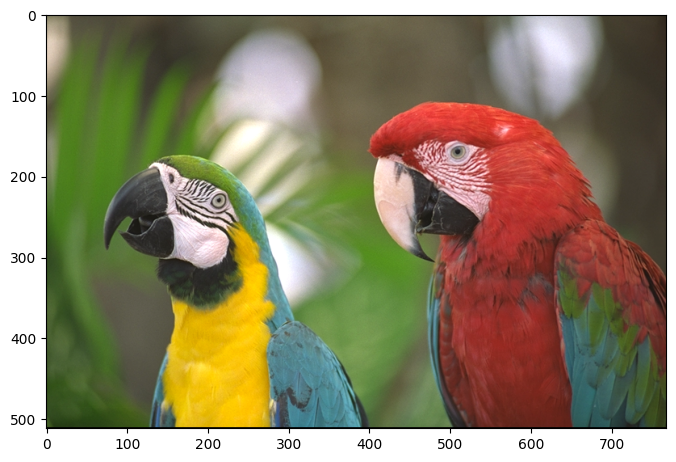

In [107]:
# Load image
img = cv2.imread('kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [108]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [109]:
# Cast the image to float
img = img.astype(np.float16)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)
sqr_white = 3 * 255 ** 2
# Apply quantization

def getQuantizedColor(pixel, colors):
    new_pixel = colors[0]
    min_sqr_quantization_error = sqr_white
    for color in colors:
        sqr_quantization_error = sum((pixel - color) ** 2)
        if sqr_quantization_error < min_sqr_quantization_error:
            min_sqr_quantization_error = sqr_quantization_error
            new_pixel = color
    return new_pixel, min_sqr_quantization_error
        

def quantize(img, colors):
    sqr_quantization_errors = []

    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img[r][c]
            
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel, min_sqr_quantization_error = getQuantizedColor(pixel, colors)
            sqr_quantization_errors.append(min_sqr_quantization_error)
            # Apply quantization
            quantized[r, c, :] = new_pixel

    return quantized, sqr_quantization_errors

quantized, sqr_quantization_errors = quantize(img, colors)


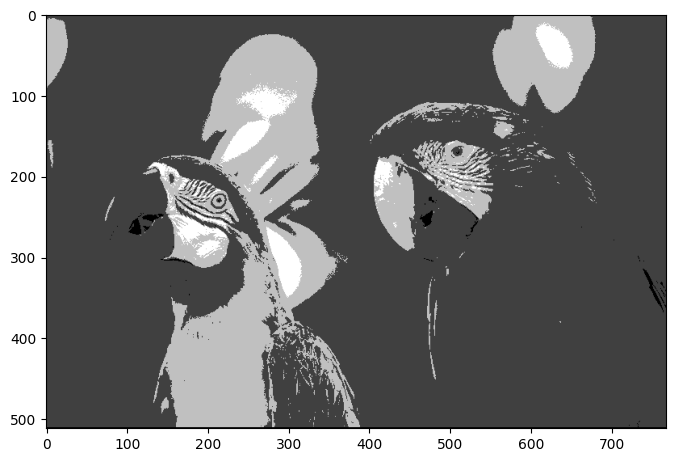

In [110]:
# Show quantized image (don't forget to cast back to uint8)
quantized = quantized.astype(np.uint8)
plt.imshow(quantized)

In [111]:
# Compute average quantization error
avg_quant_error = np.sqrt(np.mean(sqr_quantization_errors))
print('average quantization error = {}'.format(avg_quant_error))

average quantization error = 80.1304774403302


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [112]:
# Make a temporal copy of the original image, we will need it for error diffusion
def ditheringQuantize(img, colors):
    dithering = np.zeros_like(img)
    quant_errors = np.zeros_like(img)

    sqr_quantization_errors = []
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img[r][c]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel, min_sqr_quantization_error = getQuantizedColor(pixel + quant_errors[r][c], colors)         
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            quant_errors[r][c + 1] += 7/16 * quant_error  # rigth
            quant_errors[r + 1][c] += 5/16 * quant_error  # bottom 
            quant_errors[r + 1][c - 1] += 3/16 * quant_error  # bottom-left
            quant_errors[r + 1][c + 1] += 1/16 * quant_error  # bottom-right


            sqr_quantization_errors.append(min_sqr_quantization_error)
            
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            #img_tmp = 
            
            # Apply dithering
            dithering[r, c, :] = new_pixel

    return dithering, sqr_quantization_errors

dithering, sqr_quantization_errors = ditheringQuantize(img, colors)


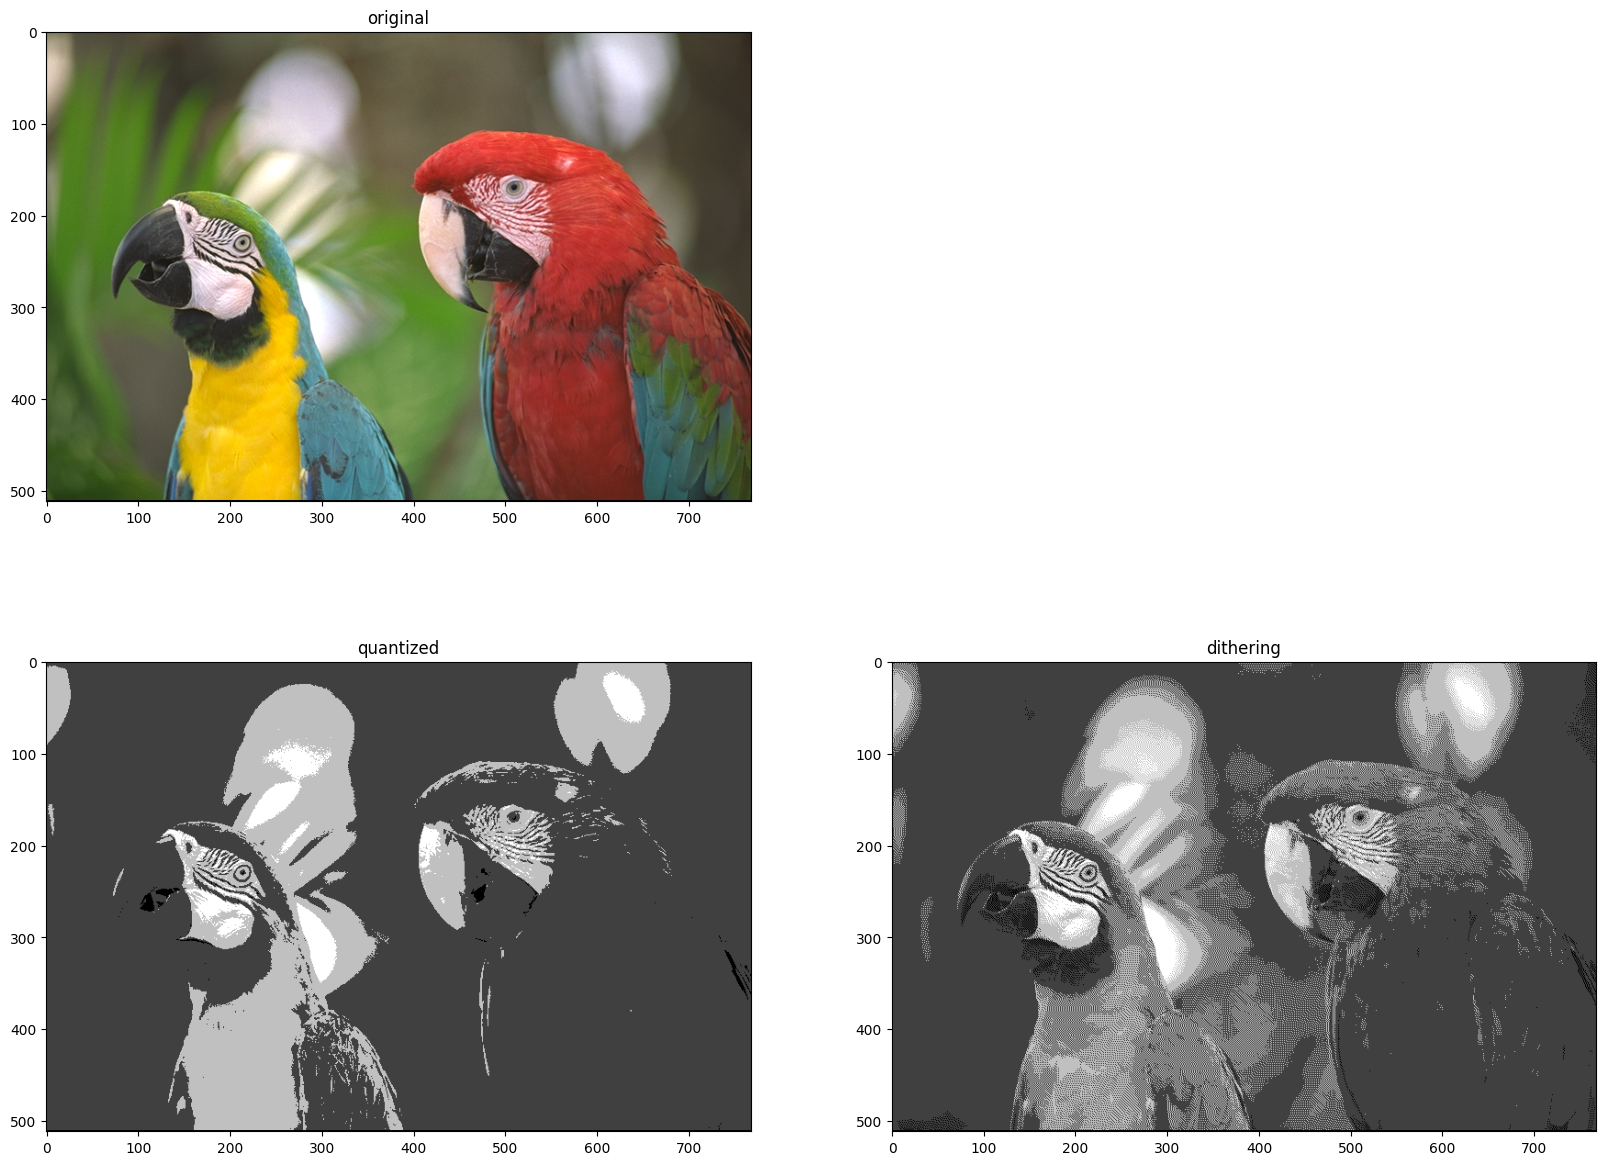

In [113]:
# Show quantized image (don't forget to cast back to uint8)
def plot(original, quantized, dithering):
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.subplot(221), plt.imshow(original.astype(np.uint8)), plt.title('original')
    plt.subplot(223), plt.imshow(quantized.astype(np.uint8)), plt.title('quantized')
    plt.subplot(224), plt.imshow(dithering.astype(np.uint8)), plt.title('dithering')
plot(img, quantized, dithering)

In [114]:
# Compute average quantization error for dithered image
avg_dith_error = np.sqrt(np.mean(sqr_quantization_errors))
print('average quantization error for dithered image = {}'.format(avg_dith_error))

average quantization error for dithered image = 136.91344726075354


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [115]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_

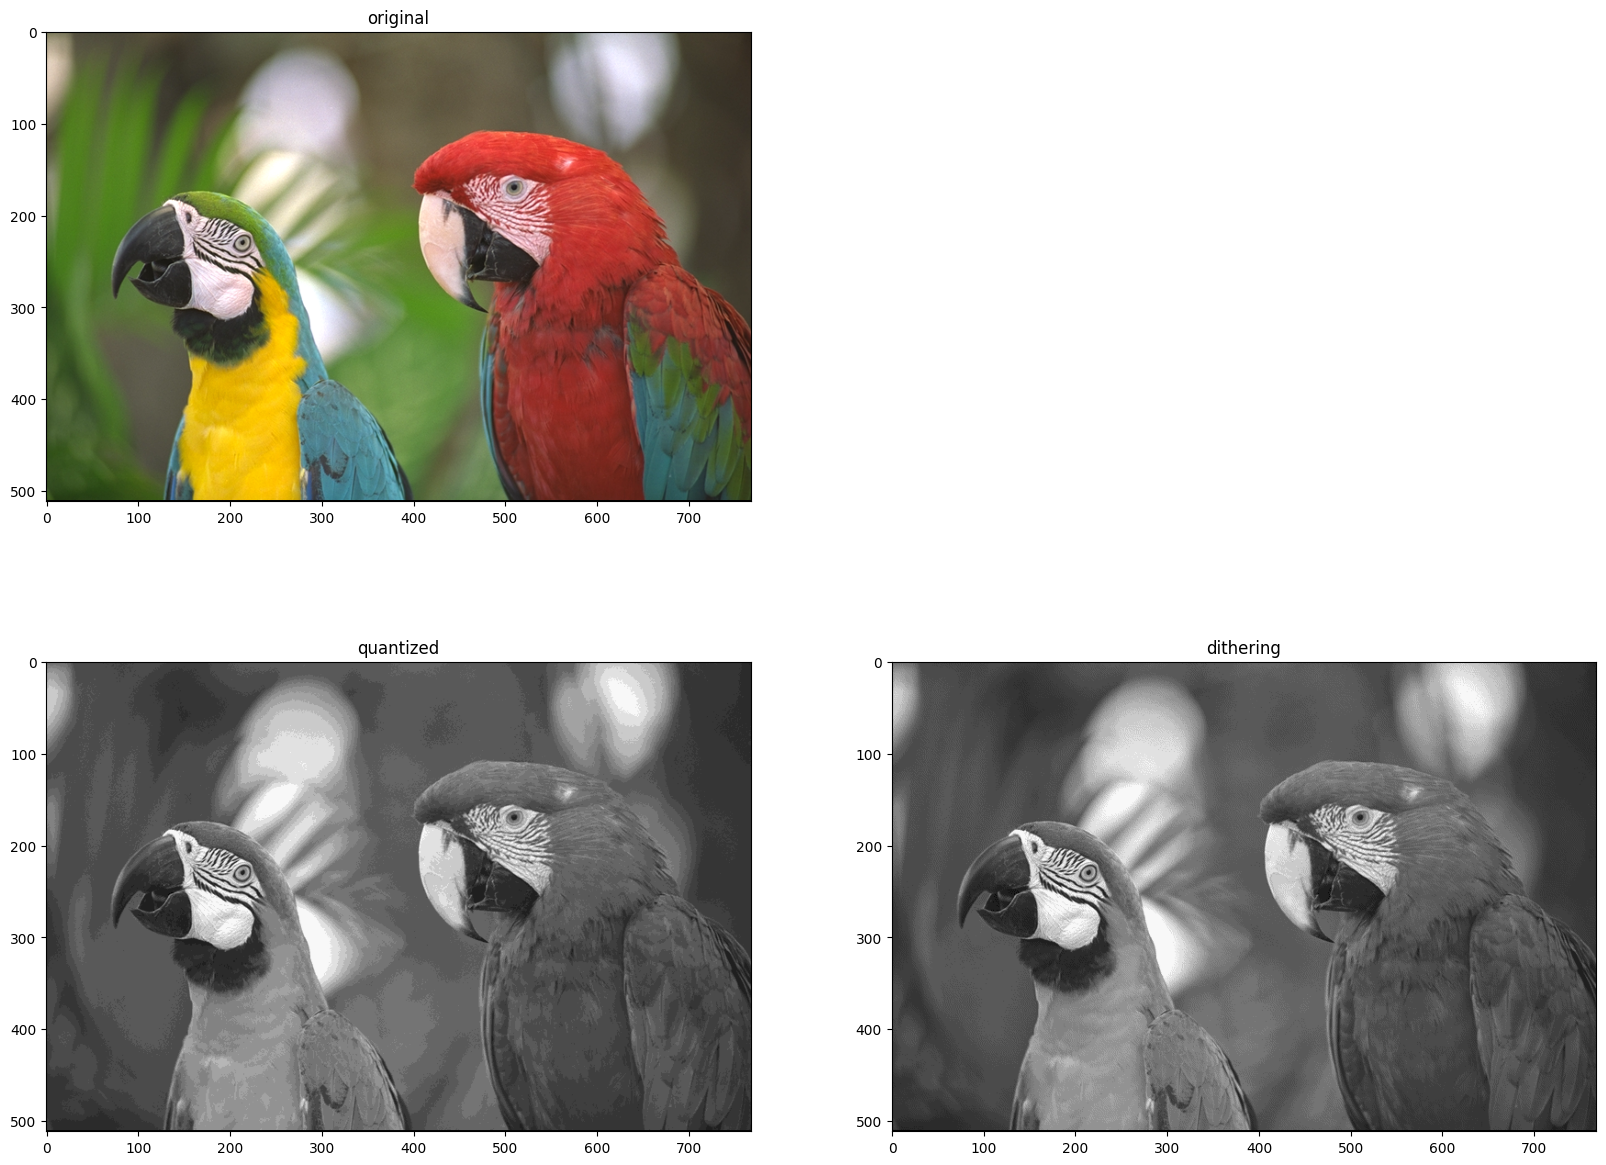

In [116]:
quantized, _ = quantize(img, colors)
dithering, _ = ditheringQuantize(img, colors)
plot(img, quantized, dithering)

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?